In [1]:
from keras.layers import Input, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import mean_squared_error
import numpy as np
import h5py
from matplotlib import rcParams  # next 3 lines set font family for plotting
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['TImes New Roman']
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})
import os
import time

# set working directory (change the following path to match your directory structure)
main = 'C:\\Users\\Kathy_Breen\\Documents\\DL_Seminar\\Week3'  # set directory path where this file is saved
os.chdir(main)  # make sure the Spyder is pointing to the correct folder

Using TensorFlow backend.


In [2]:
#%% SETTINGS FOR REPRODUCIBLE RESULTS DURING DEVELOPMENT

#import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

#import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

In [3]:
#%% Read in *.hdf5 data sets

with h5py.File('X.hdf5','r') as f:
    X_train = np.array(f["X_train"])
    X_test = np.array(f["X_test"])

with h5py.File('Y.hdf5','r') as f:
    Y_train = np.array(f["Y_train"])
    Y_test = np.array(f["Y_test"])

In [4]:
#%% Build the DLM

tic = time.time()  # start a timer

# define number of X and Y features
X_Nfeatures = X_train.shape[1]
Y_Nfeatures = Y_train.shape[1]


def run_MLP(X_Nfeatures, Y_Nfeatures, X_train, X_test, Y_train, Y_test, epochs, batch_size, do, Nlyr, Nnodes):
    # create input layer..........
    main_input = Input(shape=(X_Nfeatures),
                       dtype='float',
                       batch_shape=(batch_size,X_Nfeatures),
                       name='main_input'
                       )
    #create hidden layer..........
    hidden_layer = Dense(Nnodes, activation='relu', name='hidden_layer1')(main_input)
    # add dropout to hidden layer
    Dropout(do)(hidden_layer)
    if Nlyr > 1:
        for i in range(1,Nlyr):
            hidden_layer = Dense(Nnodes, activation='relu', name='hidden_layer'+str(i+1))(hidden_layer)
            # add dropout to hidden layer
            Dropout(do)(hidden_layer)
    
    # create output layer
    main_output = Dense(Y_Nfeatures, name='main_output')(hidden_layer)  # default activation is linear
    
    # feed datasets into model for training
    model = Model(inputs=[main_input], 
                  outputs=[main_output]
                  )
    
    # compile the model with desired configuration
    model.compile(loss='mean_squared_error',
                  optimizer='adagrad',
                  metrics=['mae'])
    
    csv_logger = CSVLogger('training_tuned' + str(epochs) + '.log')
    
    early_stop = EarlyStopping(monitor='val_loss', # quantity to monitor
                               min_delta=0.0001,  # min change to qualify as an improvement
                               patience=50, # stop after #epochs with no improvement
                               verbose=1)  # print messages
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.2,  # reduction factor (new_lr = lr * factor)
                                  patience=15,
                                  verbose=1)
    
    # train the model, and store training information in the history object
    history = model.fit([X_train],[Y_train],
                        epochs=epochs,
                        batch_size = batch_size,
                        validation_data=([X_test], [Y_test]),
                        callbacks=[reduce_lr,early_stop,csv_logger]
                        )
    histdict = history.history

    predict = model.predict([X_test],batch_size=batch_size)
    Y_mse = mean_squared_error(predict,Y_test)
    return model, histdict, predict, Y_mse

In [5]:
#%% Run the tuned model with hyperparameters identified during HP tuning
batch_size = 500
do = 0.2
Nlyr = 8
Nnodes = 75
epochs = 5000

model, histdict, predict, Y_mse = run_MLP(X_Nfeatures, Y_Nfeatures, X_train, X_test, Y_train, Y_test, epochs, batch_size, do, Nlyr, Nnodes)

Instructions for updating:
keep_dims is deprecated, use keepdims instead
Train on 90000 samples, validate on 10000 samples
Epoch 1/5000
90000/90000 [==============================] - 1s 12us/step - loss: 2.0065 - mean_absolute_error: 0.9680 - val_loss: 2.1940 - val_mean_absolute_error: 1.0276
Epoch 2/5000
90000/90000 [==============================] - 1s 7us/step - loss: 1.9888 - mean_absolute_error: 0.9697 - val_loss: 2.1907 - val_mean_absolute_error: 0.9794
Epoch 3/5000
90000/90000 [==============================] - 1s 7us/step - loss: 1.9836 - mean_absolute_error: 0.9681 - val_loss: 2.1800 - val_mean_absolute_error: 1.0198
Epoch 4/5000
90000/90000 [==============================] - 1s 8us/step - loss: 1.9538 - mean_absolute_error: 0.9609 - val_loss: 2.0070 - val_mean_absolute_error: 0.9369
Epoch 5/5000
90000/90000 [==============================] - 1s 7us/step - loss: 1.9519 - mean_absolute_error: 0.9505 - val_loss: 2.1904 - val_mean_absolute_error: 1.0015
Epoch 6/5000
90000/90000 [

Epoch 46/5000
90000/90000 [==============================] - 1s 8us/step - loss: 1.6396e-04 - mean_absolute_error: 0.0074 - val_loss: 3.2012e-04 - val_mean_absolute_error: 0.0114
Epoch 47/5000
90000/90000 [==============================] - 1s 8us/step - loss: 2.2443e-04 - mean_absolute_error: 0.0084 - val_loss: 2.1414e-04 - val_mean_absolute_error: 0.0084
Epoch 48/5000
90000/90000 [==============================] - 1s 7us/step - loss: 2.2433e-04 - mean_absolute_error: 0.0088 - val_loss: 3.5502e-04 - val_mean_absolute_error: 0.0127
Epoch 49/5000
90000/90000 [==============================] - 1s 7us/step - loss: 2.7006e-04 - mean_absolute_error: 0.0100 - val_loss: 1.1294e-04 - val_mean_absolute_error: 0.0029
Epoch 50/5000
90000/90000 [==============================] - 1s 7us/step - loss: 6.7323e-04 - mean_absolute_error: 0.0125 - val_loss: 0.0020 - val_mean_absolute_error: 0.0346
Epoch 51/5000
90000/90000 [==============================] - 1s 7us/step - loss: 3.4410e-04 - mean_absolute_e

Epoch 90/5000
90000/90000 [==============================] - 1s 7us/step - loss: 3.8418e-05 - mean_absolute_error: 0.0020 - val_loss: 5.3620e-05 - val_mean_absolute_error: 0.0021
Epoch 91/5000
90000/90000 [==============================] - 1s 7us/step - loss: 3.8366e-05 - mean_absolute_error: 0.0020 - val_loss: 5.3520e-05 - val_mean_absolute_error: 0.0021
Epoch 92/5000
90000/90000 [==============================] - 1s 7us/step - loss: 3.8341e-05 - mean_absolute_error: 0.0020 - val_loss: 5.3480e-05 - val_mean_absolute_error: 0.0021
Epoch 93/5000
90000/90000 [==============================] - 1s 7us/step - loss: 3.8307e-05 - mean_absolute_error: 0.0020 - val_loss: 5.3420e-05 - val_mean_absolute_error: 0.0021
Epoch 94/5000
90000/90000 [==============================] - 1s 7us/step - loss: 3.8263e-05 - mean_absolute_error: 0.0020 - val_loss: 5.3377e-05 - val_mean_absolute_error: 0.0021
Epoch 95/5000
85500/90000 [===========================>..] - ETA: 0s - loss: 3.9641e-05 - mean_absolute_e

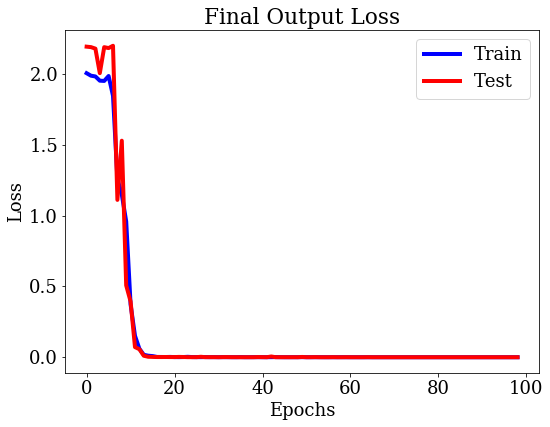

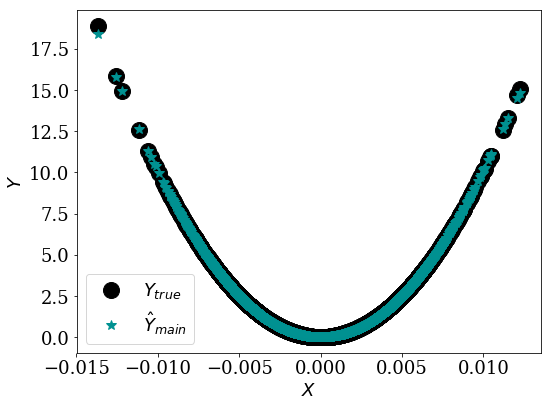

In [6]:
#%% plot

main_loss_train = histdict['loss']
main_loss_test = histdict['val_loss']
xplot = list(range(len(main_loss_train)))

fig = plt.figure(num=2, figsize=(8,6))
ax = fig.add_subplot(111)
train = ax.plot(xplot,main_loss_train,'b-',label='Train',linewidth=4)
test = ax.plot(xplot,main_loss_test,'r-',label='Test',linewidth=4)
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
curves = train+test
labels = [c.get_label() for c in curves]
ax.legend(curves, labels, loc=0)
plt.tight_layout()
plt.title('Final Output Loss')
plt.savefig('main_loss_tuned.pdf')
plt.show()

fig = plt.figure(num=3, figsize=(8,6))
ax = fig.add_subplot(111)
y_true = ax.plot(X_test,Y_test,'ko',markersize=16,label=r'$Y_{true}$')
y_pred = ax.plot(X_test,predict,'*',color='#009191',markersize=10,label=r'$\hat{Y}_{main}$')
ax.set_xlabel(r'$X$')
ax.set_ylabel(r'$Y$')
curves = y_true+y_pred
labels = [c.get_label() for c in curves]
ax.legend(curves, labels, loc=0)
plt.tight_layout()
plt.savefig('ypred2_tuned.pdf')
plt.show()